In [13]:
import kagglehub
import os
import pandas as pd
import numpy as np

#reproducibility
import random
os.environ["PYTHONHASHSEED"] = "42"
random.seed(42)
np.random.seed(42)

import sklearn
sklearn.set_config(assume_finite=True)

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [14]:
print("FITBIT DATASET:\n")
path = kagglehub.dataset_download("arashnic/fitbit")
export_folder = f"{path}/mturkfitbit_export_3.12.16-4.11.16"
data_folder = f"{export_folder}/Fitabase Data 3.12.16-4.11.16"

daily_activity = pd.read_csv(f"{data_folder}/dailyActivity_merged.csv")
sleep_day = pd.read_csv(f"{data_folder}/minuteSleep_merged.csv")
weight_log = pd.read_csv(f"{data_folder}/weightLogInfo_merged.csv")

print(f" Daily Activity: {daily_activity.shape}") #includes steps, distance, calories, activity intensity (daily summaries)
print(f" Minute Sleep: {sleep_day.shape}") # (1=asleep, 2=restless, 3=awake)
print(f" Weight Log: {weight_log.shape}") #bmi metadata
print("\nCOLUMN NAMES IN KEY DATAFRAMES:\n")
print("daily_activity.columns:", list(daily_activity.columns))
print("sleep_day.columns:", list(sleep_day.columns))



FITBIT DATASET:

Using Colab cache for faster access to the 'fitbit' dataset.
 Daily Activity: (457, 15)
 Minute Sleep: (198559, 4)
 Weight Log: (33, 8)

COLUMN NAMES IN KEY DATAFRAMES:

daily_activity.columns: ['Id', 'ActivityDate', 'TotalSteps', 'TotalDistance', 'TrackerDistance', 'LoggedActivitiesDistance', 'VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance', 'SedentaryActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories']
sleep_day.columns: ['Id', 'date', 'value', 'logId']


In [15]:
print(" Converting sleep data into daily summaries:")
sleep_day['date'] = pd.to_datetime(sleep_day['date']).dt.date

daily_sleep = (sleep_day.groupby(['Id', 'date']).agg({'value': lambda x: (x == 1).sum()})
               .rename(columns={'value': 'TotalMinutesAsleep'}).reset_index())

daily_sleep['TotalTimeInBed'] = sleep_day.groupby(['Id', 'date'])['value'].count().values
daily_sleep['TotalMinutesAwake'] = daily_sleep['TotalTimeInBed'] - daily_sleep['TotalMinutesAsleep']

daily_activity['ActivityDate'] = pd.to_datetime(daily_activity['ActivityDate'])
daily_activity['date'] = daily_activity['ActivityDate'].dt.date

df = pd.merge(daily_activity, daily_sleep, on=['Id', 'date'], how='inner')
print(f" New combined dataset: {df.shape} rows")
print(f" Sleep time ranges from {df['TotalMinutesAsleep'].min():.0f} to {df['TotalMinutesAsleep'].max():.0f} minutes")



 Converting sleep data into daily summaries:
 New combined dataset: (199, 19) rows
 Sleep time ranges from 10 to 901 minutes


In [16]:
# numeric features that exist in Fitbit dataset
features = ['TotalDistance', 'TrackerDistance', 'LoggedActivitiesDistance', 'VeryActiveDistance',
           'ModeratelyActiveDistance', 'LightActiveDistance', 'SedentaryActiveDistance',
           'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories']

features = [f for f in features if f in df.columns]
X = df[features].fillna(0)
y_regression = df['TotalMinutesAsleep']
y_classification = (df['TotalMinutesAsleep'] >= df['TotalMinutesAsleep'].median()).astype(int)

print(f" {len(features)} features defined | X.shape: {X.shape}")


 12 features defined | X.shape: (199, 12)


In [17]:
X_train_reg, X_test_reg, y_reg_train, y_reg_test = train_test_split(X, y_regression, test_size=0.2, random_state=42)
X_train_clf, X_test_clf, y_clf_train, y_clf_test = train_test_split(X, y_classification, test_size=0.2, random_state=42)

scaler_reg = StandardScaler(); scaler_clf = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg); X_test_reg_scaled = scaler_reg.transform(X_test_reg)
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf); X_test_clf_scaled = scaler_clf.transform(X_test_clf)

print(f" Train/Test Split: {X_train_reg.shape[0]}/{X_test_reg.shape[0]} (80/20)")
print(f" Scaling has been applied for non-linear models")


 Train/Test Split: 159/40 (80/20)
 Scaling has been applied for non-linear models


In [18]:
models_classification = {
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM (RBF)': SVC(kernel='rbf', C=1.0, random_state=42),
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42),  # was having problems with iterations not being enough
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}


In [19]:
from sklearn.metrics import f1_score

print("\nMODEL CLASSIFICATION ANALYSIS (ACC, F1, CV)\n")
clf_results = {}

for name, model in models_classification.items():
    print(f"Training {name:18}:", end=" ")

    if name == 'Logistic Regression':
        model.fit(X_train_clf, y_clf_train)
        y_pred = model.predict(X_test_clf)
        cv_data, cv_target = X_train_clf, y_clf_train
    else:
        model.fit(X_train_clf_scaled, y_clf_train)
        y_pred = model.predict(X_test_clf_scaled)
        cv_data, cv_target = X_train_clf_scaled, y_clf_train

    # main metrics
    accuracy = accuracy_score(y_clf_test, y_pred)
    f1 = f1_score(y_clf_test, y_pred)
    cv_scores = cross_val_score(model, cv_data, cv_target, cv=5, scoring='accuracy')

    clf_results[name] = {
        'Accuracy': accuracy,
        'F1_Score': f1,
        'CV_Accuracy': cv_scores.mean(),
        'Overfit_Gap': accuracy - cv_scores.mean()  # using to track overfitting because model was doing that
    }

    print(f"Acc={accuracy:.3f} | F1={f1:.3f} | CV={cv_scores.mean():.3f} | Gap={clf_results[name]['Overfit_Gap']:.1%}")

# balancing test performance + CV stability
best_model = max(clf_results.items(), key=lambda x:
    0.35*x[1]['Accuracy'] + 0.35*x[1]['F1_Score'] + 0.30*x[1]['CV_Accuracy']
)

best_clf_model_name, best_results = best_model

print(f"\n BEST MODEL: {best_clf_model_name}")
print(f"   Test Accuracy:  {best_results['Accuracy']:.1%}")
print(f"   F1-Score:       {best_results['F1_Score']:.1%}")
print(f"   CV Stability:   {best_results['CV_Accuracy']:.1%}")
print(f"   Overfit Gap:    {best_results['Overfit_Gap']:.1%}")
print(f"   Combined Score: {0.35*best_results['Accuracy'] + 0.35*best_results['F1_Score'] + 0.30*best_results['CV_Accuracy']:.3f}")



MODEL CLASSIFICATION ANALYSIS (ACC, F1, CV)

Training Decision Tree     : Acc=0.850 | F1=0.842 | CV=0.768 | Gap=8.2%
Training KNN               : Acc=0.775 | F1=0.769 | CV=0.724 | Gap=5.1%
Training SVM (RBF)         : Acc=0.775 | F1=0.757 | CV=0.723 | Gap=5.2%
Training Logistic Regression: Acc=0.575 | F1=0.541 | CV=0.673 | Gap=-9.8%
Training Random Forest     : Acc=0.850 | F1=0.833 | CV=0.793 | Gap=5.7%
Training Gradient Boosting : Acc=0.850 | F1=0.833 | CV=0.818 | Gap=3.2%

 BEST MODEL: Gradient Boosting
   Test Accuracy:  85.0%
   F1-Score:       83.3%
   CV Stability:   81.8%
   Overfit Gap:    3.2%
   Combined Score: 0.834


In [20]:
models_regression = {
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'SVM': SVR(kernel='rbf', C=1.0),
    'Ridge Regression': Ridge(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

print("\nREGRESSION MODEL ANALYSIS (R², MAE):")
reg_results = {}
for name, model in models_regression.items():
    model.fit(X_train_reg_scaled, y_reg_train)
    y_pred_reg = model.predict(X_test_reg_scaled)
    r2 = r2_score(y_reg_test, y_pred_reg)
    mae = mean_absolute_error(y_reg_test, y_pred_reg)
    reg_results[name] = {'R²': r2, 'MAE': mae}
    print(f"{name:18}: R²={r2:.3f} | MAE={mae:.1f}")


best_reg_model_name = max(reg_results, key=lambda x: reg_results[x]['R²'])
best_r2 = reg_results[best_reg_model_name]['R²']
best_mae = reg_results[best_reg_model_name]['MAE']

print(f"\n BEST REGRESSION: {best_reg_model_name}")
print(f"   R² = {best_r2:.3f} ({best_r2:.1%} variance explained)")
print(f"   MAE = {best_mae:.1f} minutes")




REGRESSION MODEL ANALYSIS (R², MAE):
Decision Tree     : R²=0.488 | MAE=73.5
KNN               : R²=0.484 | MAE=91.0
SVM               : R²=-0.016 | MAE=127.0
Ridge Regression  : R²=0.372 | MAE=100.0
Random Forest     : R²=0.693 | MAE=60.9
Gradient Boosting : R²=0.640 | MAE=65.1

 BEST REGRESSION: Random Forest
   R² = 0.693 (69.3% variance explained)
   MAE = 60.9 minutes


In [21]:
# best models for report
models_regression[best_reg_model_name].fit(X_train_reg_scaled, y_reg_train)
y_reg_pred_final = models_regression[best_reg_model_name].predict(X_test_reg_scaled)
final_r2 = r2_score(y_reg_test, y_reg_pred_final); final_mae = mean_absolute_error(y_reg_test, y_reg_pred_final)

if best_clf_model_name == 'Logistic Regression':
    models_classification[best_clf_model_name].fit(X_train_clf, y_clf_train)
    y_clf_pred_final = models_classification[best_clf_model_name].predict(X_test_clf)
else:
    models_classification[best_clf_model_name].fit(X_train_clf_scaled, y_clf_train)
    y_clf_pred_final = models_classification[best_clf_model_name].predict(X_test_clf_scaled)

clf_accuracy = accuracy_score(y_clf_test, y_clf_pred_final); clf_f1 = f1_score(y_clf_test, y_clf_pred_final)

print(f"BEST REGRESSION: {best_reg_model_name} | R²={final_r2:.3f} | MAE={final_mae:.1f} minutes")
print(f"BEST CLASSIFICATION: {best_clf_model_name} | Accuracy={clf_accuracy:.3f} | F1={clf_f1:.3f}")
print("\nClassification Report:\n", classification_report(y_clf_test, y_clf_pred_final, target_names=['Poor Sleep', 'Good Sleep']))



BEST REGRESSION: Random Forest | R²=0.693 | MAE=60.9 minutes
BEST CLASSIFICATION: Gradient Boosting | Accuracy=0.850 | F1=0.833

Classification Report:
               precision    recall  f1-score   support

  Poor Sleep       0.86      0.86      0.86        22
  Good Sleep       0.83      0.83      0.83        18

    accuracy                           0.85        40
   macro avg       0.85      0.85      0.85        40
weighted avg       0.85      0.85      0.85        40



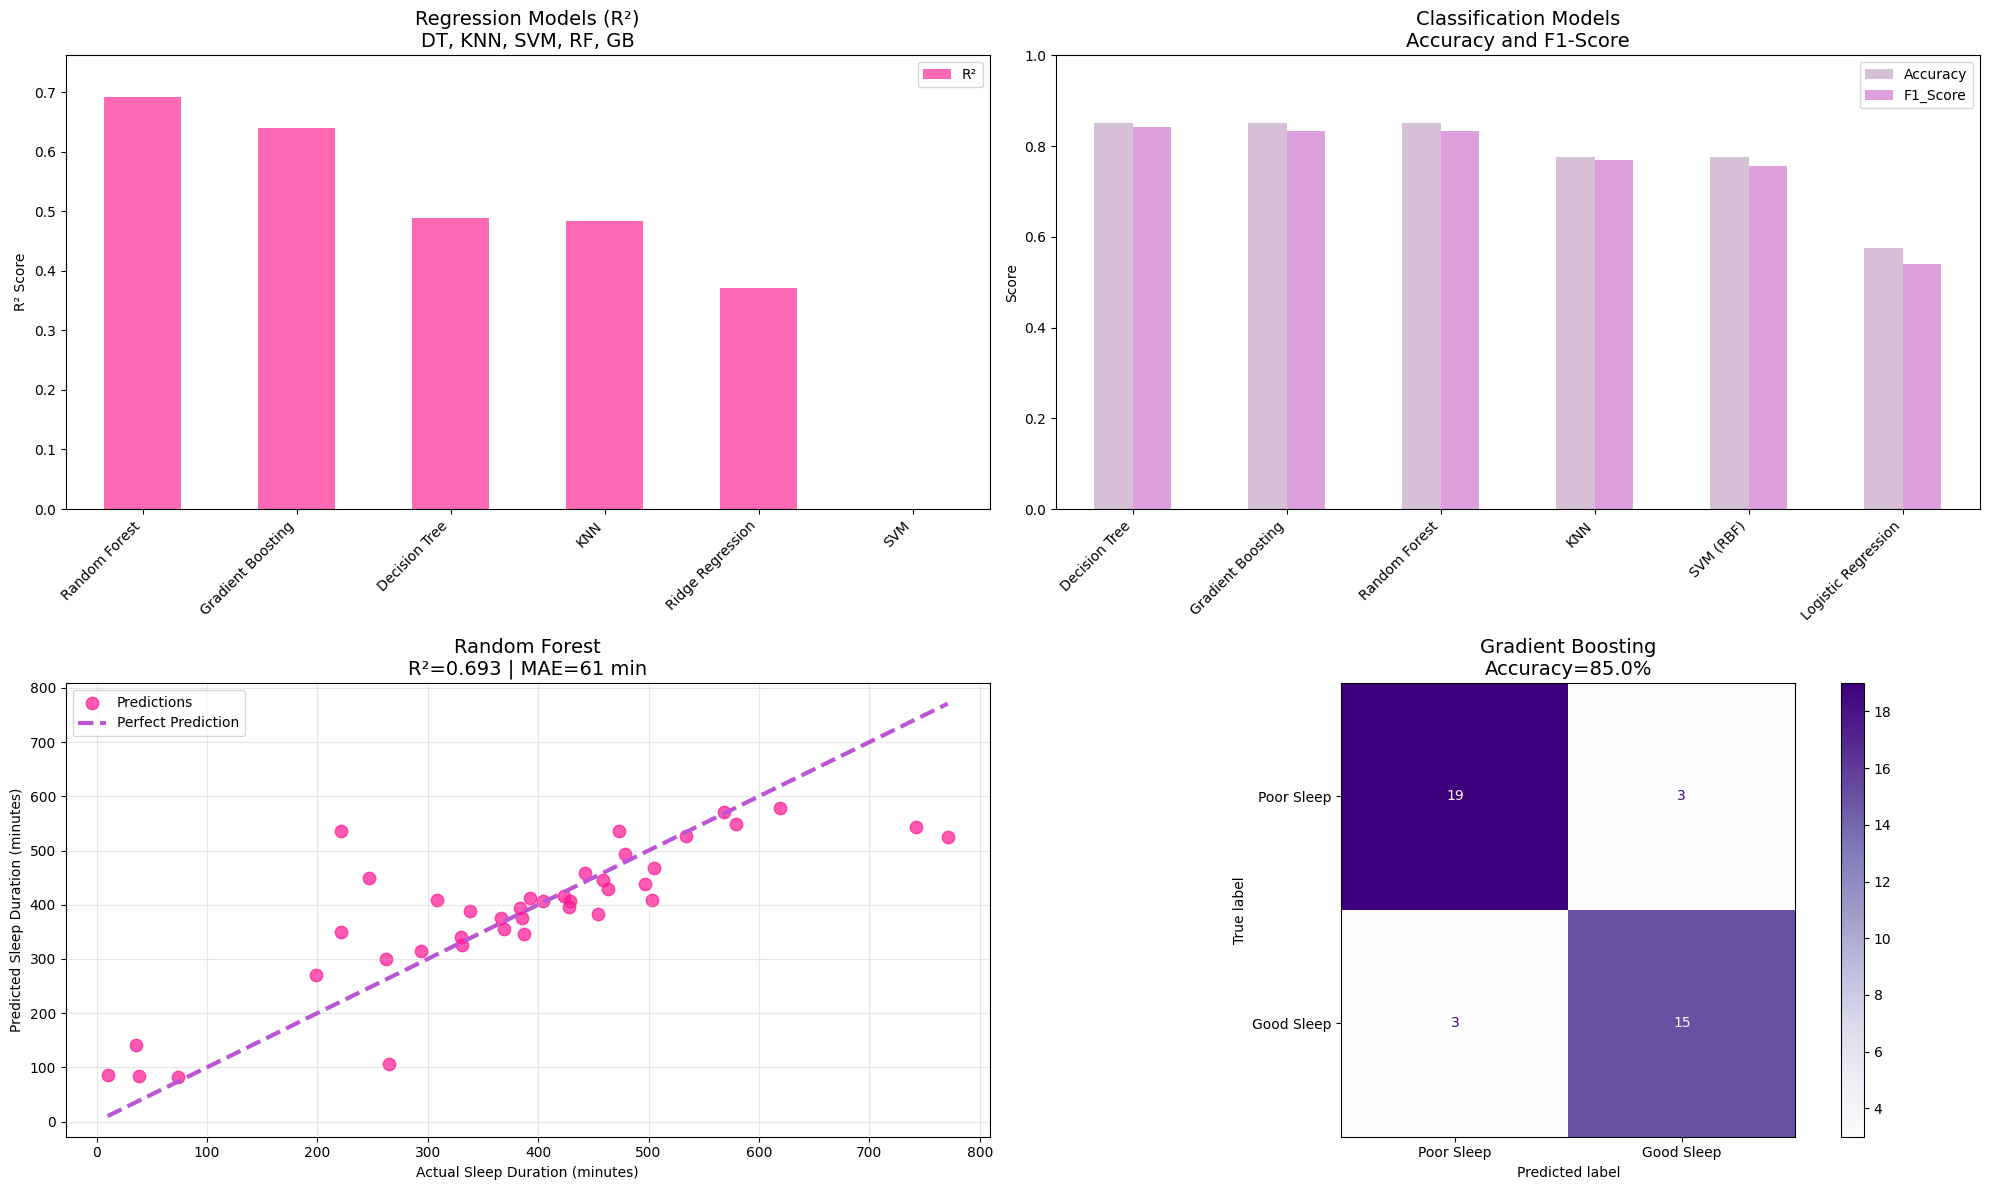

In [22]:
plt.figure(figsize=(20, 12))

# regression comparison
plt.subplot(2, 2, 1)
reg_df = pd.DataFrame(reg_results).T[['R²']].sort_values('R²', ascending=False)
reg_df.plot(kind='bar', ax=plt.gca(), color='hotpink')
plt.title('Regression Models (R²)\nDT, KNN, SVM, RF, GB', fontsize=14)
plt.ylabel('R² Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, max(reg_df['R²'])*1.1)

# classification comparison
plt.subplot(2, 2, 2)
clf_df = pd.DataFrame(clf_results).T[['Accuracy', 'F1_Score']].sort_values('Accuracy', ascending=False)
clf_df.plot(kind='bar', ax=plt.gca(), color=['thistle', 'plum'])
plt.title('Classification Models\nAccuracy and F1-Score', fontsize=14)
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(['Accuracy', 'F1_Score'])
plt.ylim(0, 1)

# regression scatter plot
plt.subplot(2, 2, 3)
plt.scatter(y_reg_test, y_reg_pred_final, alpha=0.7, s=80, color='deeppink', label='Predictions')
plt.plot(
    [y_reg_test.min(), y_reg_test.max()],
    [y_reg_test.min(), y_reg_test.max()],
    color='mediumorchid', lw=3, linestyle='--', label='Perfect Prediction'
)
plt.xlabel('Actual Sleep Duration (minutes)')
plt.ylabel('Predicted Sleep Duration (minutes)')
plt.title(f'{best_reg_model_name}\nR²={final_r2:.3f} | MAE={final_mae:.0f} min', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# confusion matrix
plt.subplot(2, 2, 4)
cm = confusion_matrix(y_clf_test, y_clf_pred_final)
disp = ConfusionMatrixDisplay(cm, display_labels=['Poor Sleep', 'Good Sleep'])
disp.plot(cmap='Purples', ax=plt.gca())
plt.title(f'{best_clf_model_name}\nAccuracy={clf_accuracy:.1%}', fontsize=14)

plt.tight_layout()
plt.show()



 Analyzing Factors: What Actually Drives Sleep Time & Quality?


 Using 12 safe features

CORRELATION ANALYSIS:

TOP SLEEP DURATION CORRELATIONS:
SedentaryActiveDistance    -0.012
ModeratelyActiveDistance   -0.063
LightlyActiveMinutes       -0.071
LightActiveDistance        -0.086
FairlyActiveMinutes        -0.101
Name: TotalMinutesAsleep, dtype: float64

TOP SLEEP QUALITY CORRELATIONS:
Calories                    0.258
LoggedActivitiesDistance    0.116
VeryActiveMinutes           0.106
SedentaryActiveDistance     0.096
VeryActiveDistance          0.085
dtype: float64

ML MODEL RANKINGS:

 TOP PREDICTORS:
                 Feature  Importance_SleepTime  Importance_SleepQuality
10      SedentaryMinutes                 0.677                    0.401
9   LightlyActiveMinutes                 0.068                    0.053
11              Calories                 0.060                    0.123
7      VeryActiveMinutes                 0.038                    0.053
0          TotalDistance   

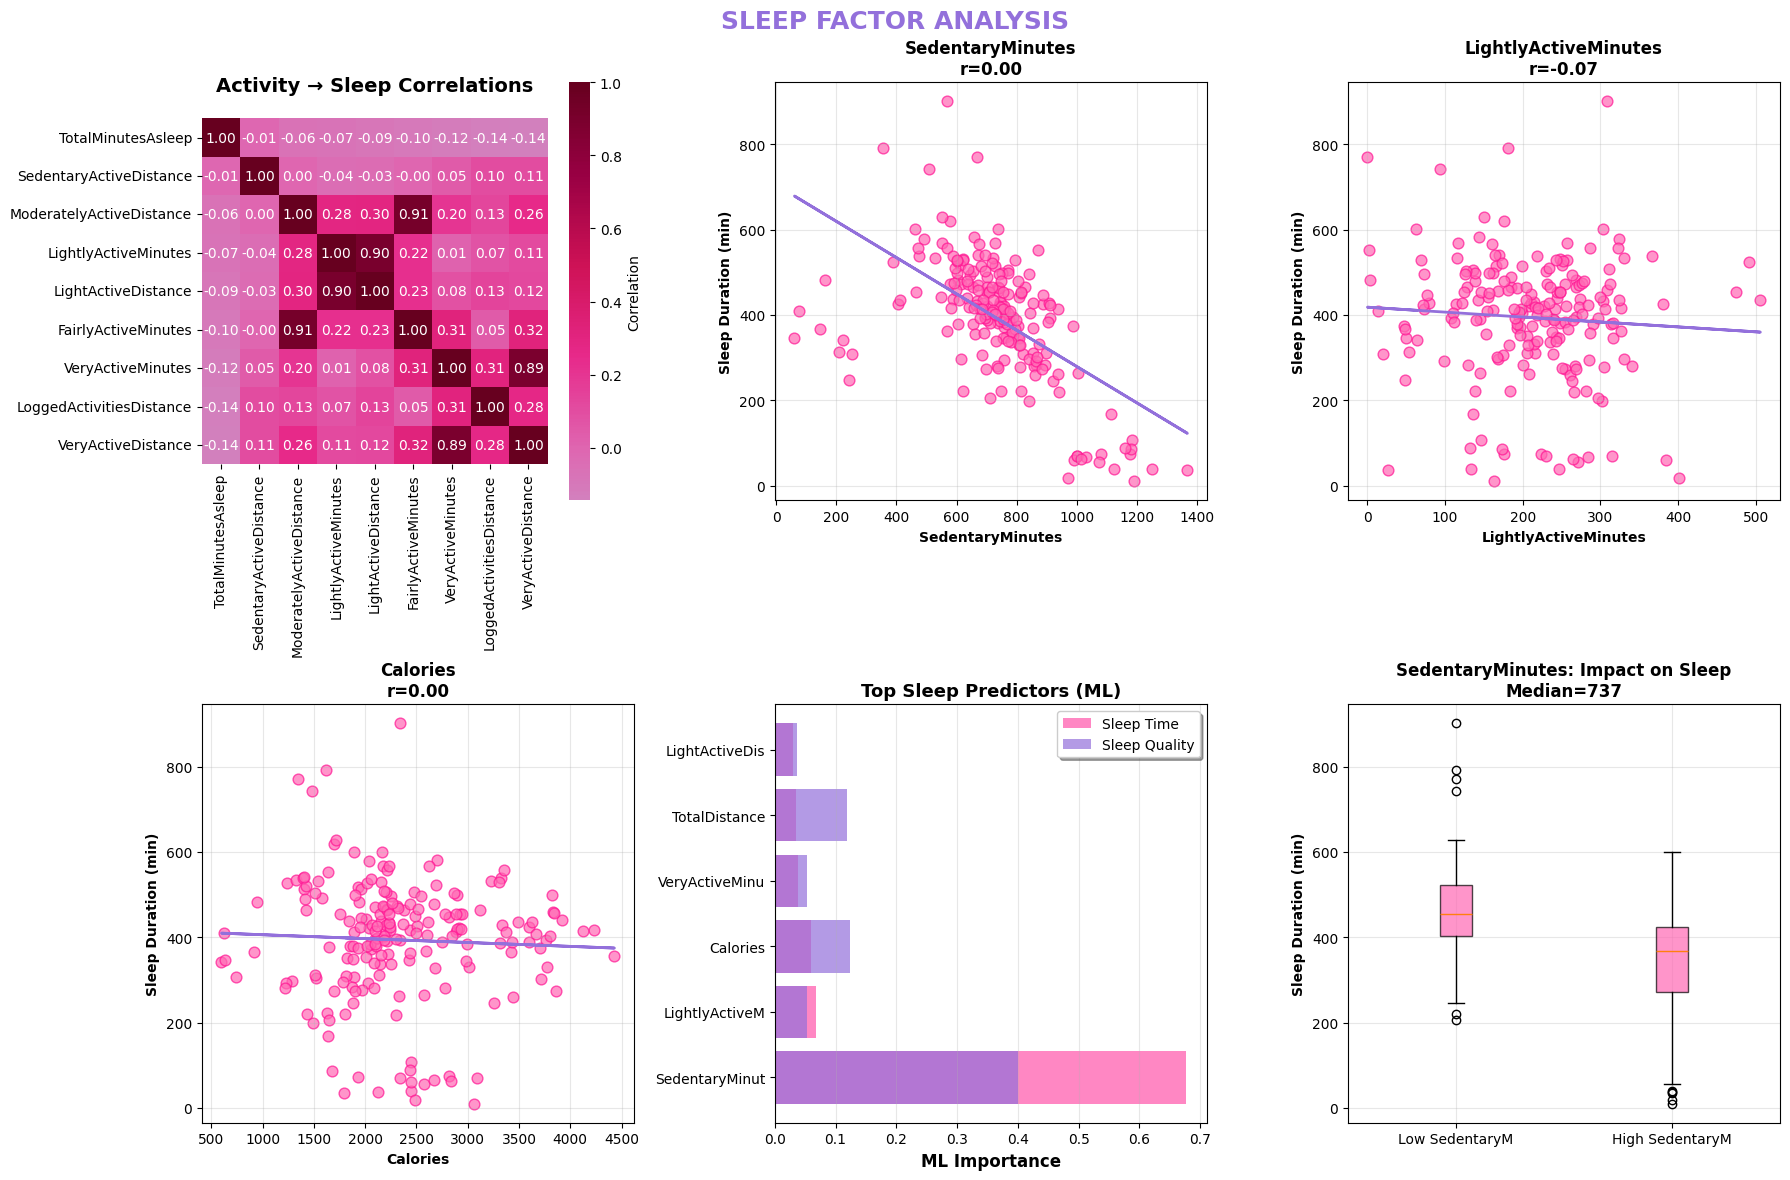


SUMMARY
TOP PREDICTOR: SedentaryMinutes
   ML Imp (Time):  67.7%
   ML Imp (Quality): 40.1%
 Correlation: 0.000

RESULTS:
             Feature  Importance_SleepTime  Importance_SleepQuality
    SedentaryMinutes                 0.677                    0.401
LightlyActiveMinutes                 0.068                    0.053
            Calories                 0.060                    0.123
   VeryActiveMinutes                 0.038                    0.053
       TotalDistance                 0.034                    0.119


In [23]:
print(" Analyzing Factors: What Actually Drives Sleep Time & Quality?")
print("\n" )

# handle empty lists
features = [f for f in features if f in df.columns]
if len(features) == 0:
    features = [col for col in df.columns if col not in ['Id', 'TotalMinutesAsleep', 'TotalTimeInBed']]
print(f" Using {len(features)} safe features")

print("\nCORRELATION ANALYSIS:")

# correlation calculation
if len(features) > 0 and 'TotalMinutesAsleep' in df.columns:
    corr_sleep_duration = df[['TotalMinutesAsleep'] + features[:10]].corr()['TotalMinutesAsleep'].drop('TotalMinutesAsleep', errors='ignore').sort_values(ascending=False)
else:
    corr_sleep_duration = pd.Series(dtype=float)
    print("No valid features for correlation")

sleep_efficiency = df['TotalMinutesAsleep'] / df['TotalTimeInBed']
corr_sleep_efficiency = pd.Series(dtype=float)
for feature in features:
    if feature in df.columns:
        corr_sleep_efficiency[feature] = sleep_efficiency.corr(df[feature])
corr_sleep_efficiency = corr_sleep_efficiency.dropna().sort_values(ascending=False)

print("\nTOP SLEEP DURATION CORRELATIONS:")
print(corr_sleep_duration.head().round(3))
print("\nTOP SLEEP QUALITY CORRELATIONS:")
print(corr_sleep_efficiency.head().round(3))

print("\nML MODEL RANKINGS:")
time_importance = quality_importance = None

# ML importance extraction (was running into issues with execution)
if 'best_reg_model_name' in locals() and best_reg_model_name in ['Random Forest', 'Gradient Boosting', 'Decision Tree']:
    try:
        models_regression[best_reg_model_name].fit(X_train_reg_scaled, y_reg_train)
        time_importance = models_regression[best_reg_model_name].feature_importances_
    except:
        print("Regression model failed")

if 'best_clf_model_name' in locals() and best_clf_model_name in ['Random Forest', 'Gradient Boosting', 'Decision Tree']:
    try:
        if best_clf_model_name == 'Logistic Regression':
            models_classification[best_clf_model_name].fit(X_train_clf, y_clf_train)
        else:
            models_classification[best_clf_model_name].fit(X_train_clf_scaled, y_clf_train)
        quality_importance = models_classification[best_clf_model_name].feature_importances_
    except:
        print("Classification model failed")

# combined DataFrame
if time_importance is not None and len(time_importance) == len(features):
    combined = pd.DataFrame({
        'Feature': features,
        'Importance_SleepTime': time_importance,
        'Importance_SleepQuality': quality_importance if quality_importance is not None else np.zeros(len(features)),
        'Correlation_SleepTime': corr_sleep_duration.reindex(features).fillna(0).values,
        'Correlation_SleepQuality': corr_sleep_efficiency.reindex(features).fillna(0).values
    }).sort_values('Importance_SleepTime', ascending=False)
    top_features = combined.head(5)['Feature'].tolist()
    print("\n TOP PREDICTORS:")
    print(combined[['Feature', 'Importance_SleepTime', 'Importance_SleepQuality']].head().round(3))
else:
    top_features = corr_sleep_duration.head(5).index.tolist() if len(corr_sleep_duration) > 0 else features[:5]

# statisitical tests
print("\nSTATISTICAL SIGNIFICANCE:")
from scipy.stats import pearsonr
for feature in top_features[:5]:
    if feature in df.columns:
        corr, p_value = pearsonr(df[feature], df['TotalMinutesAsleep'])
        sig = '***' if p_value<0.001 else '**' if p_value<0.01 else '*' if p_value<0.05 else ''
        print(f"{feature:20}: r={corr:.3f}, p={p_value:.3f} {sig}")

# visualiztion
plt.figure(figsize=(18, 12))

# heatmap
plt.subplot(2, 3, 1)
top_corr_features = corr_sleep_duration.head(8).index.tolist()
safe_corr_features = [f for f in top_corr_features if f in df.columns]
if len(safe_corr_features) > 0:
    corr_matrix = df[['TotalMinutesAsleep'] + safe_corr_features].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='PuRd', center=0, fmt='.2f',
                square=True, cbar_kws={'label': 'Correlation'})
plt.title('Activity → Sleep Correlations', fontsize=14, fontweight='bold', pad=20)

# scatterplots of top 3
for i, feature in enumerate(top_features[:3]):
    plt.subplot(2, 3, i+2)
    if feature in df.columns:
        plt.scatter(df[feature], df['TotalMinutesAsleep'], alpha=0.7, s=60, color='hotpink', edgecolors='deeppink')
        z = np.polyfit(df[feature], df['TotalMinutesAsleep'], 1)
        p = np.poly1d(z)
        plt.plot(df[feature], p(df[feature]), color='mediumpurple', lw=2)
        corr_val = corr_sleep_duration.get(feature, 0)
        plt.xlabel(feature, fontweight='bold')
        plt.ylabel('Sleep Duration (min)', fontweight='bold')
        plt.title(f'{feature}\nr={corr_val:.2f}', fontsize=12, fontweight='bold')
        plt.grid(True, alpha=0.3)

# feature importance
plt.subplot(2, 3, 5)
if 'combined' in locals() and 'Importance_SleepTime' in combined.columns:
    top_factors = combined.head(6)
    x = np.arange(len(top_factors))
    plt.barh(x, top_factors['Importance_SleepTime'], alpha=0.8, label='Sleep Time', color='hotpink')
    if 'Importance_SleepQuality' in top_factors.columns and quality_importance is not None:
        plt.barh(x, top_factors['Importance_SleepQuality'], alpha=0.7, label='Sleep Quality', color='mediumpurple')
    plt.yticks(x, [f[:14] for f in top_factors['Feature']], fontsize=10)
    plt.xlabel('ML Importance', fontweight='bold', fontsize=12)
    plt.title('Top Sleep Predictors (ML)', fontweight='bold', fontsize=13)
    plt.legend(frameon=True, fancybox=True, shadow=True)
    plt.grid(True, alpha=0.3, axis='x')
else:
    plt.text(0.5, 0.5, 'No ML\nModels', ha='center', va='center', transform=plt.gca().transAxes, fontsize=16)
    plt.title('Feature Importance')

# boxplot
plt.subplot(2, 3, 6)
if len(top_features) > 0 and top_features[0] in df.columns:
    top_feature = top_features[0]
    median_val = df[top_feature].median()
    low_group = df[df[top_feature] < median_val]['TotalMinutesAsleep']
    high_group = df[df[top_feature] >= median_val]['TotalMinutesAsleep']

    bp = plt.boxplot([low_group, high_group], tick_labels=[f'Low {top_feature[:10]}', f'High {top_feature[:10]}'],
                     patch_artist=True, boxprops=dict(facecolor='hotpink', alpha=0.7))
    plt.ylabel('Sleep Duration (min)', fontweight='bold')
    plt.title(f'{top_feature}: Impact on Sleep\nMedian={median_val:.0f}', fontweight='bold')
    plt.grid(True, alpha=0.3)

plt.suptitle('SLEEP FACTOR ANALYSIS', fontsize=18, fontweight='bold', y=0.98, color='mediumpurple')
plt.tight_layout()
plt.show()

# summary
print("\nSUMMARY")
print(f"TOP PREDICTOR: {top_features[0] if len(top_features)>0 else 'N/A'}")

if 'combined' in locals():
    time_imp = combined['Importance_SleepTime'].iloc[0]
    print(f"   ML Imp (Time):  {time_imp:.1%}")
    if quality_importance is not None:
        qual_imp = combined['Importance_SleepQuality'].iloc[0]
        print(f"   ML Imp (Quality): {qual_imp:.1%}")

print(f" Correlation: {corr_sleep_duration.get(top_features[0], 0):.3f}")

print("\nRESULTS:")
if 'combined' in locals():
    display_df = combined[['Feature', 'Importance_SleepTime', 'Importance_SleepQuality']].head(5).round(3)
    print(display_df.to_string(index=False))
else:
    fallback_df = pd.DataFrame({'Feature': top_features[:5], 'Correlation': corr_sleep_duration.head().values}).round(3)
    print(fallback_df.to_string(index=False))